In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import kaiserord, firwin
from scipy.optimize import fmin

# Step 1: Helper Functions

def reverse_alternate_subbands(input_tensor):
    mask = torch.ones_like(input_tensor)
    mask[..., 1::2, ::2] = -1
    return input_tensor * mask

def pad_to_next_power_of_two(input_tensor):
    current_size = input_tensor.shape[-1]
    next_power_of_two = 2**np.ceil(np.log2(current_size))
    padding_size = int(next_power_of_two - current_size)
    return nn.functional.pad(input_tensor, (padding_size // 2, padding_size // 2 + padding_size % 2))

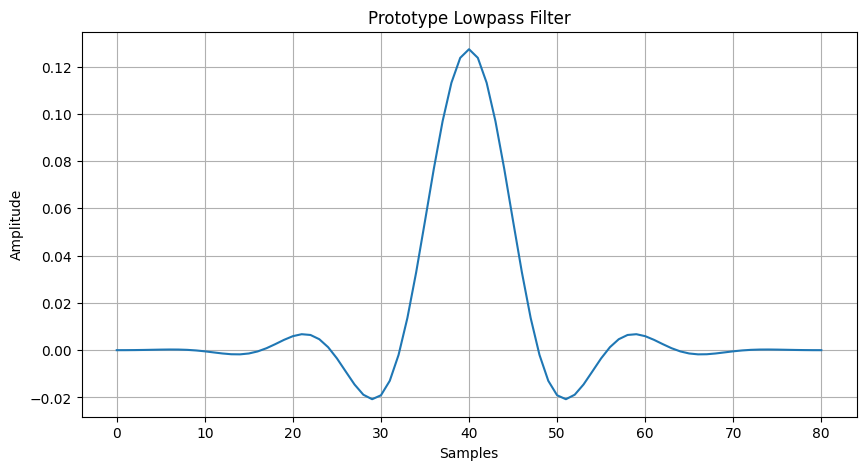

In [2]:
# Step 2 filter desgin

def design_kaiser_lowpass(cutoff_freq, attenuation, num_taps=None):
    if num_taps is None:
        num_taps, beta = kaiserord(attenuation, cutoff_freq / np.pi)
        num_taps = 2 * (num_taps // 2) + 1  # Ensure odd length
    else:
        _, beta = kaiserord(attenuation, cutoff_freq / np.pi)
    
    return firwin(num_taps, cutoff_freq / np.pi, window=('kaiser', beta), scale=False)

# Let's design a prototype filter and visualize it
attenuation = 80  # dB
cutoff_freq = 0.4  # Normalized frequency

prototype_filter = design_kaiser_lowpass(cutoff_freq, attenuation)

plt.figure(figsize=(10, 5))
plt.plot(prototype_filter)
plt.title("Prototype Lowpass Filter")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

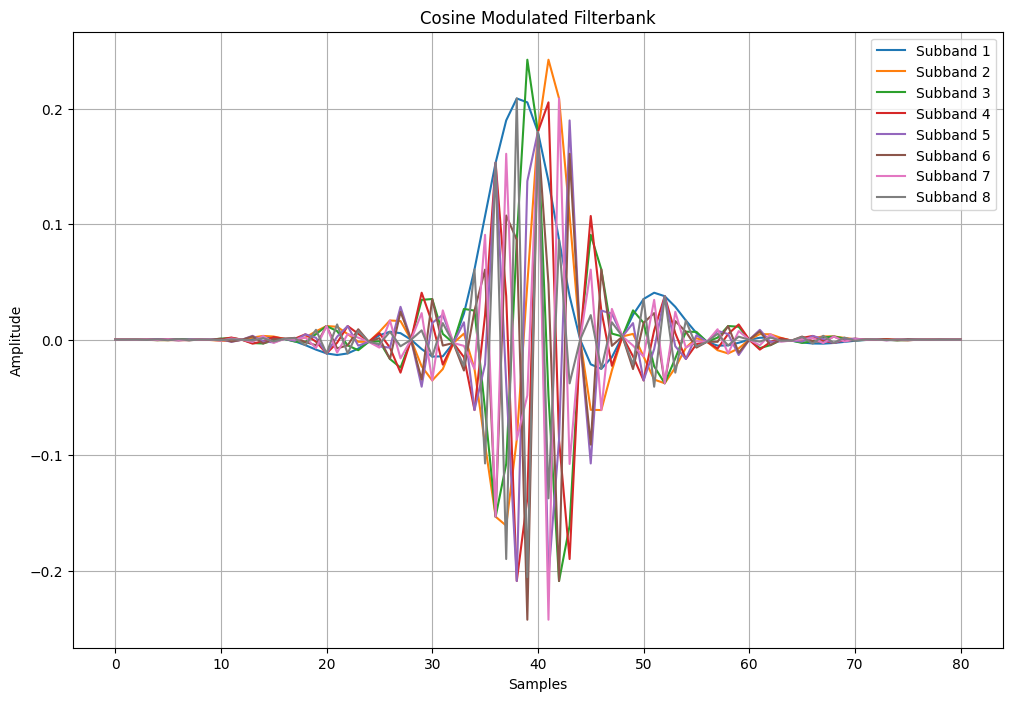

In [3]:

# Step 3: Cosine Modulation

def create_cosine_modulated_filterbank(prototype_filter, num_subbands):
    filter_length = len(prototype_filter)
    subband_indices = np.arange(num_subbands).reshape(-1, 1)
    time_indices = np.arange(-(filter_length // 2), filter_length // 2 + 1)
    
    phase_shift = (-1)**subband_indices * np.pi / 4
    modulation = np.cos((2 * subband_indices + 1) * np.pi / (2 * num_subbands) * time_indices + phase_shift)
    
    return 2 * prototype_filter * modulation

# Create a filterbank with 8 subbands
num_subbands = 8
filter_bank = create_cosine_modulated_filterbank(prototype_filter, num_subbands)

plt.figure(figsize=(12, 8))
for i in range(num_subbands):
    plt.plot(filter_bank[i], label=f'Subband {i+1}')
plt.title("Cosine Modulated Filterbank")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

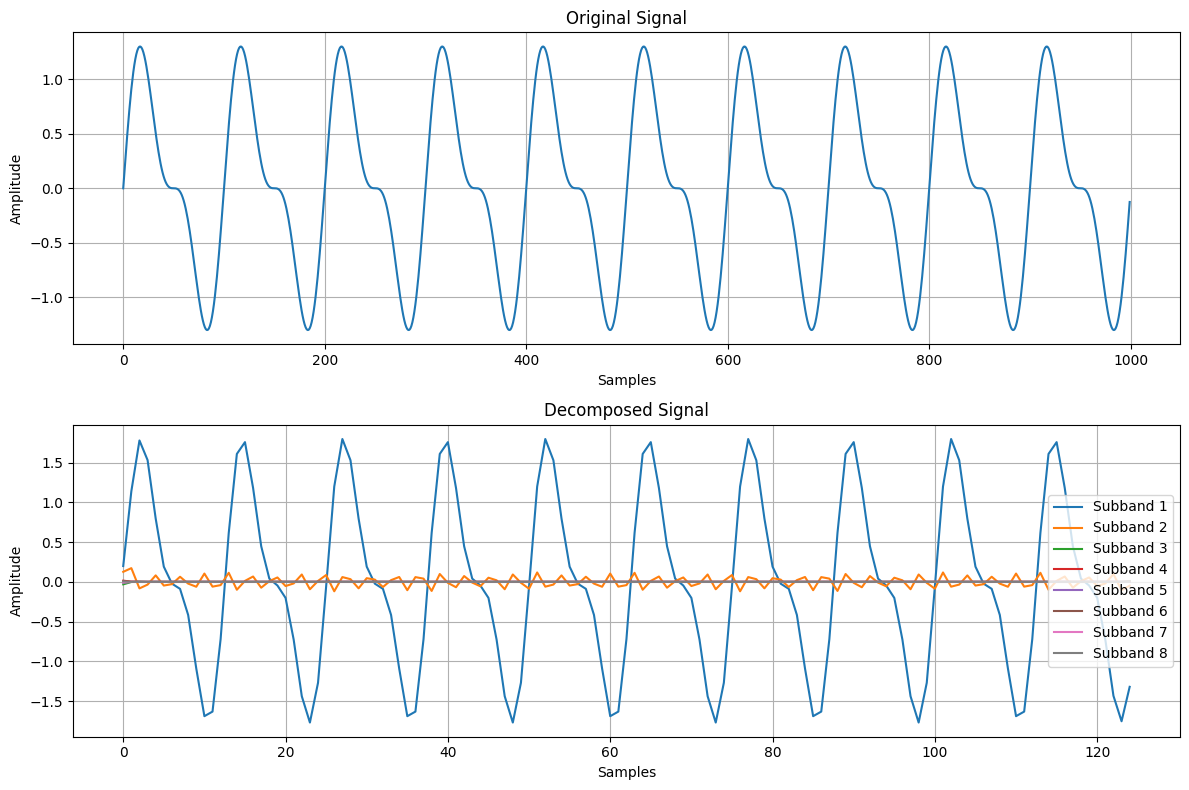

In [4]:
# Step 4: PQMF Analysis (Decomposition)

def pqmf_analysis(input_signal, filter_bank):
    num_subbands = filter_bank.shape[0]
    analyzed_signal = nn.functional.conv1d(
        input_signal.unsqueeze(0).unsqueeze(0),
        torch.from_numpy(filter_bank).float().unsqueeze(1),
        stride=num_subbands,
        padding=filter_bank.shape[1] // 2
    ).squeeze(0)
    
    return reverse_alternate_subbands(analyzed_signal)

# Generate a test signal
t = np.linspace(0, 1, 1000, endpoint=False)
test_signal = np.sin(2 * np.pi * 10 * t) + 0.5 * np.sin(2 * np.pi * 20 * t)

# Perform PQMF analysis
analyzed_signal = pqmf_analysis(torch.from_numpy(test_signal).float(), filter_bank)

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(test_signal)
plt.title("Original Signal")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)

plt.subplot(2, 1, 2)
for i in range(num_subbands):
    plt.plot(analyzed_signal[i].numpy(), label=f'Subband {i+1}')
plt.title("Decomposed Signal")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# Step 5: PQMF Synthesis (Reconstruction)

def pqmf_synthesis(input_signal, filter_bank):
    num_subbands = filter_bank.shape[0]
    reversed_signal = reverse_alternate_subbands(input_signal)
    
    filter_bank = np.flip(filter_bank, axis=1)
    filter_bank = filter_bank.reshape(num_subbands, -1, num_subbands).transpose(1, 0, 2).reshape(-1, num_subbands)
    
    temp_signal = torch.zeros(1, num_subbands, num_subbands * input_signal.shape[1])
    temp_signal[0, :, ::num_subbands] = reversed_signal * num_subbands
    
    reconstructed_signal = nn.functional.conv1d(
        temp_signal,
        torch.from_numpy(filter_bank).float().unsqueeze(1),
        padding=filter_bank.shape[0] // 2
    ).squeeze()
    
    return reconstructed_signal

# Perform PQMF synthesis
reconstructed_signal = pqmf_synthesis(analyzed_signal, filter_bank)

plt.figure(figsize=(12, 8))
plt.plot(test_signal, label='Original')
plt.plot(reconstructed_signal.numpy(), label='Reconstructed', linestyle='--')
plt.title("Original vs Reconstructed Signal")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

ValueError: cannot reshape array of size 648 into shape (8,newaxis,8)

In [ ]:


# Step 6: Complete PQMF Class

class PQMF(nn.Module):
    def __init__(self, num_subbands, attenuation):
        super().__init__()
        prototype_filter = design_kaiser_lowpass(0.4, attenuation)
        filter_bank = create_cosine_modulated_filterbank(prototype_filter, num_subbands)
        self.register_buffer("filter_bank", torch.from_numpy(filter_bank).float())
        self.num_subbands = num_subbands

    def forward(self, x):
        return pqmf_analysis(x, self.filter_bank.numpy())

    def inverse(self, x):
        return pqmf_synthesis(x, self.filter_bank.numpy())

# Test the PQMF class
pqmf = PQMF(num_subbands=8, attenuation=80)
test_tensor = torch.from_numpy(test_signal).float()

decomposed = pqmf(test_tensor)
reconstructed = pqmf.inverse(decomposed)

plt.figure(figsize=(12, 8))
plt.plot(test_tensor.numpy(), label='Original')
plt.plot(reconstructed.numpy(), label='Reconstructed', linestyle='--')
plt.title("PQMF Class: Original vs Reconstructed Signal")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

# Conclusion
print("Mean Squared Error between original and reconstructed signal:")
print(nn.MSELoss()(test_tensor, reconstructed).item())